## Mapping Richmond's Sewer System

Most Data from ArcGIS user DOEE_GIS
* https://www.arcgis.com/home/search.html?q=owner%3A%22DOEE_GIS%22&t=content&restrict=false

The City of Richmond also has a limited CSS map
* https://www.arcgis.com/home/item.html?id=3721d8f1c55a4044b65ec4563072a713

In [2]:
import json
import pandas as pd
import requests
from arcgis2geojson import arcgis2geojson
import geopandas as gpd

import os


In [43]:
# Set up the parameters

# Endpoints
urls = {'cso_boundaries': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Richmond_CSO_Boundary_Delineation/FeatureServer/0/query', 
        'ss_gravity': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Sewer_System_Gravity_Pipe/FeatureServer/0/query',
        'storm_sewer': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/ArcGIS/rest/services/Storm_System_Pipe/FeatureServer/0/query',
        # this seems to be the same as the COR CSS map's "CSS Outfalls" layer
        #'css_outfalls13': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/arcgis/rest/services/CSO_2013_Overflow_Volume_20200508/FeatureServer/0/query',
        # this seems to be the above one, but with extra features added for 2019 data?
        'css_outfalls19': 'https://services1.arcgis.com/8eq00iyMv7Ls2xme/arcgis/rest/services/CSO_Volume_2019/FeatureServer/0/query'
        # "CSS Outfalls Old"
        # https://services1.arcgis.com/k3vhq11XkBNeeOfM/arcgis/rest/services/CSO_Outfalls/FeatureServer/0/query
       }

params = dict(
    f='json',
    where='1=1',
    returnGeometry='true',
    spatialRel='esriSpatialRelIntersects',
    geometryType='esriGeometryEnvelope',
    inSR=None,
    outFields='*',
    orderByFields=None,
    outSR=None,
    resultOffset=0,
    resultRecordCount=10
)


In [7]:
import requests
import json
import pandas as pd
import math
import geopandas as gpd
from arcgis2geojson import arcgis2geojson
from io import StringIO 

def get_arcgisjson(url, params):
    print(f"URL: {url}")
    # find max row count
    max_count_params = dict(
        f='json',
        where='1=1',
        returnIdsOnly='true' # special query param, returns ALL (no limit) OBJECTIDs (or whatever the ID column is)
    )
    resp = requests.get(url=url, params=max_count_params)
    ids = resp.json() 
    # total count of objectIds
    rowcount = len(ids['objectIds'])
    pages = math.ceil(rowcount / 1000) 
    print(f"{rowcount} total items, {pages} pages to get")
    # load all the data
    # use a json obj, no df needed
    jo = {}
    pagelen = 1000
    params['resultRecordCount'] = pagelen
    for i in range(0,pages): # set this to 1 or 2 for testing
        params['resultOffset'] = i*pagelen
        #print(f"Request {str(i)}: {params['resultOffset']}")
        print('.', end='', flush=True)
        resp = requests.get(url=url, params=params)
        data = resp.json() 
        print('-', end='', flush=True)
        # JSON processing
        if i==0:
            jo = data
        else:
            jo['features'] = jo['features'] + data['features']
    # convert ESRI json to geoJSON
    gjo = arcgis2geojson(jo)
    # get crs (coordinate reference system) from response
    wkid = jo['spatialReference']['latestWkid']
    gjo['wkid'] = wkid
    return gjo

def arcgisjson_to_gdf(filename, wkid=3857, out_crs=2284):
    # read GeoJSON into GeoPandas
    gdf = gpd.read_file(filename) 
    gdf.crs = wkid # see https://github.com/geopandas/geopandas/issues/1449 - arcgis2geojson is not correctly transforming the CRS to GeoJSON default
    gdf = gdf.to_crs(out_crs) 
    return gdf

In [8]:
out_crs = 2284 # commonly used with Richmond GIS data?

In [9]:
if not os.path.isfile('data/cso_boundaries.json'):
    csob_json = get_arcgisjson(urls['cso_boundaries'], params)
    with open('data/cso_boundaries.json', 'w') as fp:
        json.dump(csob_json, fp)

csob = arcgisjson_to_gdf('data/cso_boundaries.json', wkid=3857, out_crs=out_crs)

In [10]:
if not os.path.isfile('data/ss_gravity.json'):
    ssg_json = get_arcgisjson(urls['ss_gravity'], params)
    for r in ssg_json['features']:
        # the GlobalID contains curly braces which Fiona complains about in JSON
        r['properties']['GlobalID'] = r['properties']['GlobalID'].replace("{","").replace("}","")
    print(f"WKID:{ssg_json['wkid']}")
    with open('data/ss_gravity.json', 'w') as fp:
        json.dump(ssg_json, fp)

ss_gravity = arcgisjson_to_gdf('data/ss_gravity.json', wkid=3857, out_crs=out_crs)

In [12]:
if not os.path.isfile('data/storm_sewer.json'):
    ss_json = get_arcgisjson(urls['storm_sewer'], params)
    for r in ss_json['features']:
        # the GlobalID contains curly braces which Fiona complains about in JSON
        r['properties']['GlobalID'] = r['properties']['GlobalID'].replace("{","").replace("}","")
    wkid=ss_json['wkid']
    print(f"WKID:{wkid}")
    with open('data/storm_sewer.json', 'w') as fp:
        json.dump(ss_json, fp)

storm_sewer = arcgisjson_to_gdf('data/storm_sewer.json', wkid=3857, out_crs=out_crs)

In [44]:
if not os.path.isfile('data/CSO_Volume_2019.json'):
    temp_json = get_arcgisjson(urls['css_outfalls19'], params)
    wkid=temp_json['wkid']
    print(f"WKID:{wkid}")
    with open('data/CSO_Volume_2019.json', 'w') as fp:
        json.dump(temp_json, fp)

cso_volume = arcgisjson_to_gdf('data/CSO_Volume_2019.json', wkid=3857, out_crs=out_crs)

URL: https://services1.arcgis.com/8eq00iyMv7Ls2xme/arcgis/rest/services/CSO_Volume_2019/FeatureServer/0/query
37 total items, 1 pages to get
.-

WKID:3857


In [ ]:
# Save resources to shapefiles for portability
csob.to_file(driver = 'ESRI Shapefile', filename="shapefile/richmond_cso_boundaries.shp")
ss_gravity.to_file(driver = 'ESRI Shapefile', filename="shapefile/richmond_sewer_gravity_pipes.shp")


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [13]:
storm_sewer.to_file(driver = 'ESRI Shapefile', filename="shapefile/richmond_storm_sewers.shp")

In [45]:
cso_volume.to_file(driver = 'ESRI Shapefile', filename="shapefile/CSO_Volume_2019.shp")

## Plotting

In [19]:
# for the background (base layer), I'm just loading the road shapes. there's a bunch of other options
# From Richmond GIS FTP - ftp://ftp.ci.richmond.va.us/GIS/Shapefiles/Basemap/
rvaroads = gpd.read_file('Basemap/base_Road.shp')
rvastreams = gpd.read_file('Basemap/base_StreamPolygon.shp')
rvalakes = gpd.read_file('Basemap/base_LakePolygon.shp')

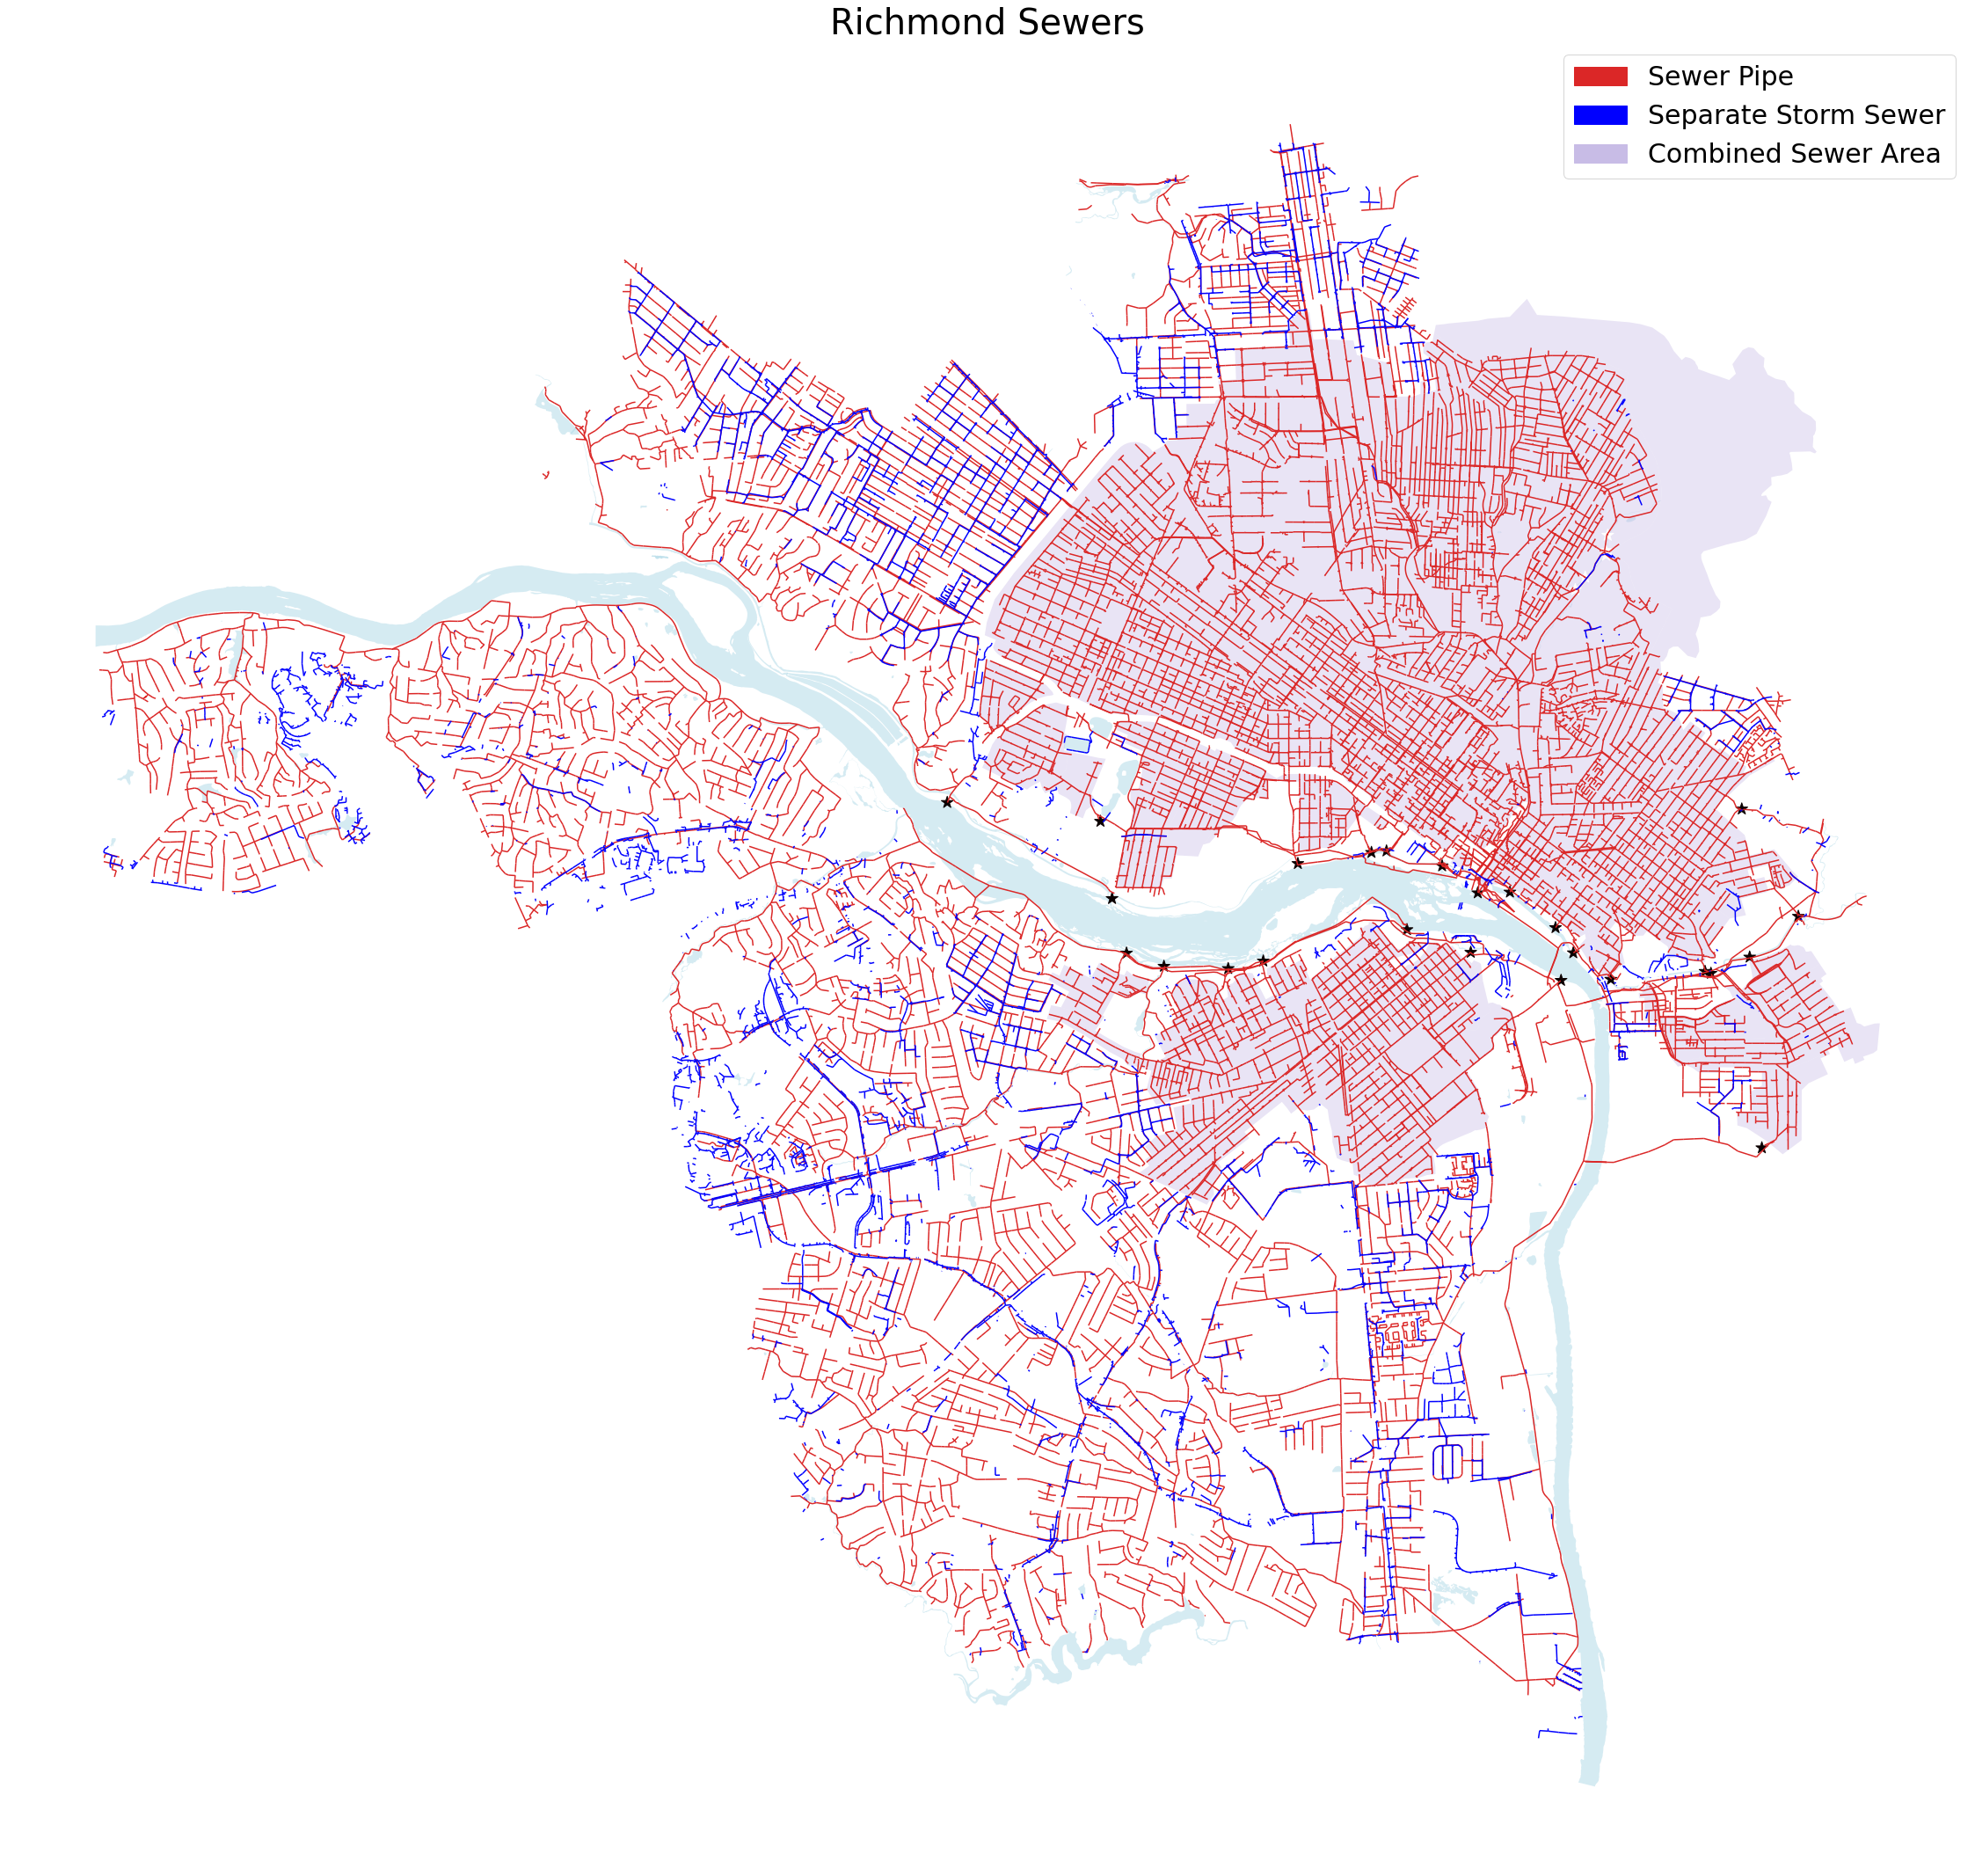

In [54]:
from matplotlib import pyplot as plt
# let's do some plottttts
fig = plt.figure(figsize=(40,40)) # controls resolution - figure size in inches
ax = fig.add_subplot()

# plot a base layer
#rvaroads.plot(ax=ax, color='white', edgecolor='#999999')
rvastreams.plot(ax=ax, color="#add8e6", alpha=0.5)
rvalakes.plot(ax=ax, color="#add8e6", alpha=0.5)

csob.plot(color="#c8bce6", ax=ax, alpha=0.4) # was "Layer",
ss_gravity.plot(ax=ax, color="#db2727")
#ss_gravity.plot("System", ax=ax, legend=True)
storm_sewer.plot(ax=ax, color="blue")
cso_volume.plot("TYPE", ax=ax, marker="*", markersize=200, cmap="hot")

ax.set_title('Richmond Sewers', fontsize=40)

# manual legend
import matplotlib.patches as mpatches
sewer = mpatches.Patch(color='#db2727', label='Sewer Pipe')
storm = mpatches.Patch(color='blue', label='Separate Storm Sewer')
cso = mpatches.Patch(color='#c8bce6', label='Combined Sewer Area')
plt.legend(handles=[sewer, storm, cso], fontsize=30)

plt.axis('off')

#plt.show(fig)
plt.savefig("pics/sewers.png", facecolor='white', bbox_inches='tight')

In [46]:
cso_volume

FID  OBJECTID                TYPE CSO_NUMBER    POINT_X    POINT_Y  \
0     1         1         CSO Outfall        012 -77.397534  37.506883   
1     2         2         CSO Outfall        025 -77.393622  37.528446   
2     3         3         CSO Outfall        031 -77.400366  37.538755   
3     4         4         CSO Outfall        026 -77.399573  37.524630   
4     5         5         CSO Outfall        024 -77.404199  37.523136   
5     6         6         CSO Outfall        039 -77.404849  37.523316   
6     7         7  Closed CSO Outfall        028 -77.412364  37.522339   
7     8         8         CSO Outfall        004 -77.415965  37.522593   
8     9         9         CSO Outfall        005 -77.420537  37.525227   
9    10        10         CSO Outfall        035 -77.422578  37.527509   
10   11        11         CSO Outfall        034 -77.427905  37.531020   
11   12        12         CSO Outfall        006 -77.431710  37.530987   
12   13        13         CSO Outfall        007 -77.436299  37.533843   
13   14        14         CSO Outfall        009 -77.442502  37.535052   
14   15        15         CSO Outfall        010 -77.444501  37.534938   
15   16        16         CSO Outfall        011 -77.453152  37.533592   
16   17        17         CSO Outfall        019 -77.475183  37.530703   
17   18        18         CSO Outfall        033 -77.476580  37.538176   
18   19        19         CSO Outfall        020 -77.494959  37.540089   
19   20        20         CSO Outfall        021 -77.421803  37.522667   
20   21        21         CSO Outfall        014 -77.432852  37.525414   
21   22        22         CSO Outfall        040 -77.439819  37.528111   
22   23        23         CSO Outfall        015 -77.457358  37.524783   
23   24        24         CSO Outfall        016 -77.461426  37.524125   
24   25        25         CSO Outfall        017 -77.469212  37.524380   
25   26        26         CSO Outfall        018 -77.473682  37.525716   
26   27        27  Closed CSO Outfall        002   0.000000   0.000000   
27   28        28  Closed CSO Outfall        003   0.000000   0.000000   
28   29        29  Closed CSO Outfall        013   0.000000   0.000000   
29   30        30  Closed CSO Outfall        023   0.000000   0.000000   
30   31        31  Closed CSO Outfall        027   0.000000   0.000000   
31   32        32  Closed CSO Outfall        036   0.000000   0.000000   
32   33        33  Closed CSO Outfall       006A   0.000000   0.000000   
33   34        35  Closed CSO Outfall       006B   0.000000   0.000000   
34   35        37  Closed CSO Outfall       006C   0.000000   0.000000   
35   36        39  Closed CSO Outfall       006E   0.000000   0.000000   
36   37        41  Closed CSO Outfall       006D   0.000000   0.000000   

                         NAME  total_2013  CSO_num  perc_2013    CSO  \
0               Hilton Street           6       12        0.2  CSO12   
1          Briel & Gillies Cr          10       25        0.3  CSO25   
2                 Oakwood Cem           3       31        0.1  CSO31   
3           Gov't Road & NSRR           2       26        0.1  CSO26   
4            Gillies & Varina          15       24        0.5  CSO24   
5        Gov't Road & Gillies          21       39        0.7  CSO39   
6                 W'Burg Road           5       28        0.2  CSO28   
7                  Bloody Run          17        4        0.6  CSO04   
8                Peach Street           1        5        0.0  CSO05   
9                 29th & Dock           0       35        0.0  CSO35   
10                19th & Dock          69       34        2.4  CSO34   
11                    Shockoe        2315        6       80.5  CSO06   
12                      Byrd3           0        7        0.0  CSO07   
13  6th (CSO 8) & 7th Streets           0        9        0.0  CSO09   
14               Gambles Hill           1       10        0.0  CSO10   
15                 Park Hydro          